In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import bm3d
import os
import importlib
import optics as op
from noise import gauss_noise, poisson_noise, salt_pepper_noise, mix_noise

<Figure size 640x480 with 0 Axes>

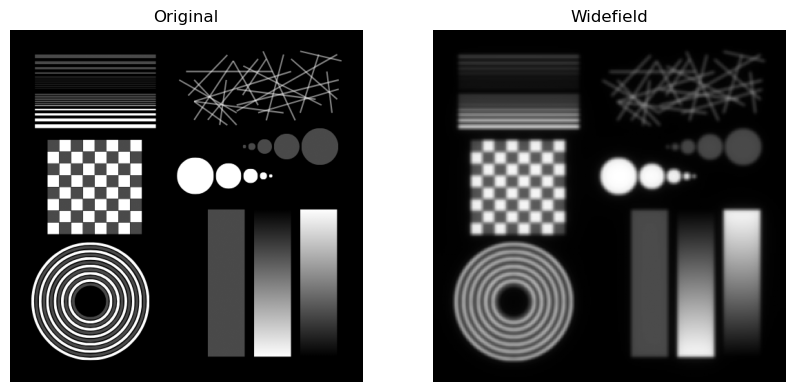

In [49]:
plt.set_cmap('gray')

# Visulaize how the ground truth looks like in widefield

synthetic = ski.img_as_float(ski.color.rgb2gray(ski.io.imread('source_images\Synthetic512.png')))

synthetic256 = op.otf_incoherent(synthetic, NA=1.2, wavelength=680, pixelsize=100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(synthetic)
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(synthetic256)
ax[1].set_title("Widefield")
ax[1].axis('off')
plt.show()

In [50]:
synthetic256circle = op.circle_lowpass(synthetic, 128)
print(synthetic256.min(), synthetic256.max(), synthetic256.mean())
synthetic256 = op.otf_incoherent(synthetic, NA=1.2, wavelength=680, pixelsize=100)
print(synthetic256circle.min(), synthetic256circle.max(), synthetic256circle.mean())
print(synthetic.mean())


-0.7511364963165752 5.032336780708446 0.7410517673866421
0.0 1.0 0.1904114138038062
0.0 1.0 0.25800901849602537
0.18526294184666056


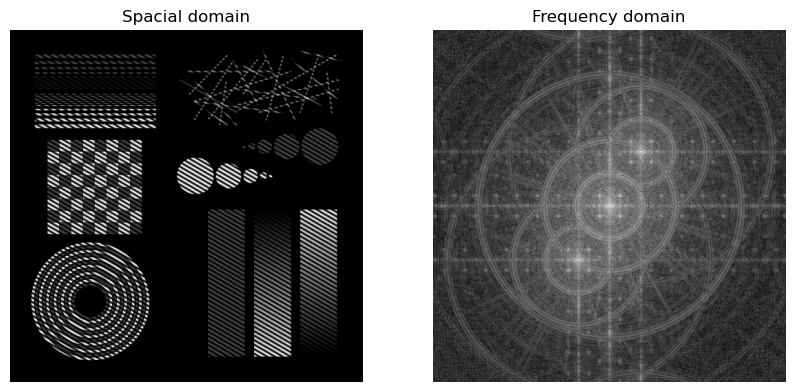

In [51]:
synthetic_grated = np.zeros((9, synthetic.shape[0], synthetic.shape[1]))

for i in range(3):
    for j in range(3):
        synthetic_grated[3*i + j] = synthetic * op.grating(len(synthetic), 120 * i,  120 * j, NA=1.2, wavelength=680, pixelsize=100)

op.display_fourier(synthetic_grated[3])

In [52]:
# Add noise to the images
percentage = 0.1
folder_path = 'output_images/stitched'
synthetic_grated_gaussian = gauss_noise(synthetic_grated, percentage)
synthetic_grated_poisson = poisson_noise(synthetic_grated, percentage)
synthetic_grated_saltpepper = salt_pepper_noise(synthetic_grated, percentage)
synthetic_grated_mix = mix_noise(synthetic_grated, percentage)

# Apply low-pass filter
synthetic_grated_gaussian_256 = op.otf_incoherent(synthetic_grated_gaussian, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_poisson_256 = op.otf_incoherent(synthetic_grated_poisson, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_saltpepper_256 = op.otf_incoherent(synthetic_grated_saltpepper, NA=1.2, wavelength=600, pixelsize=100)
synthetic_grated_mix_256 = op.otf_incoherent(synthetic_grated_mix, NA=1.2, wavelength=600, pixelsize=100)

In [53]:
# Print range and mean intensity
print(np.min(synthetic_grated_gaussian_256), np.max(synthetic_grated_gaussian_256), np.mean(synthetic_grated_gaussian_256))
print(np.min(synthetic_grated_poisson_256), np.max(synthetic_grated_poisson_256), np.mean(synthetic_grated_poisson_256))
print(np.min(synthetic_grated_saltpepper_256), np.max(synthetic_grated_saltpepper_256), np.mean(synthetic_grated_saltpepper_256))
print(np.min(synthetic_grated_mix_256), np.max(synthetic_grated_mix_256), np.mean(synthetic_grated_mix_256))

0.0 1.0 0.20037770409005365
0.0 1.0 0.1772029500057013
0.0 1.0 0.183723531118954
0.0 1.0 0.18428533527588062


In [54]:
synthetic_grated_256 = op.otf_incoherent(synthetic_grated) # Ground truth
noisy_image = synthetic_grated_mix_256

noisy_PSNR = np.zeros(9)
noisy_SSIM = np.zeros(9)
for i in range(9):
    noisy_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], noisy_image[i])
    noisy_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], noisy_image[i], data_range=1)

print("Noisy PSNR: ", np.mean(noisy_PSNR))
print("Noisy SSIM: ", np.mean(noisy_SSIM))


# op.display_fourier(synthetic_grated_256[0]) # Noise free image

# Save images
# ski.io.imsave(os.path.join(folder_path, 'synthetic_grated_circle_256.tif'), synthetic_grated_256)
# ski.io.imsave(os.path.join(folder_path, 'noisy_image_256.tif'), noisy_image)

Noisy PSNR:  29.13289951371601
Noisy SSIM:  0.7662521932393519


(-0.5, 140.5, 130.5, -0.5)

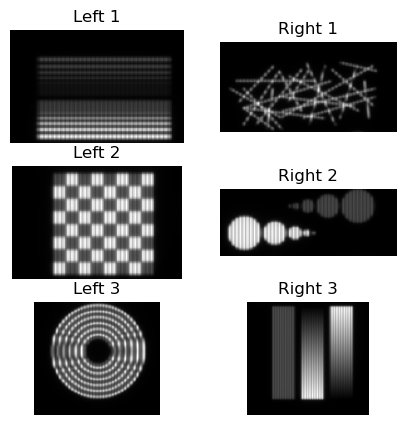

In [55]:
# Splitting ground truth
l1 = synthetic_grated_256[:, :75, :115]
l2 = synthetic_grated_256[:, 75:152, :115]
l3 = synthetic_grated_256[:, 152:, :115]
r1 = synthetic_grated_256[:, :72, 115:]
r2 = synthetic_grated_256[:, 72:125, 115:]
r3 = synthetic_grated_256[:, 125:, 115:]

# Splitting noisy image
nl1 = noisy_image[:, :75, :115]
nl2 = noisy_image[:, 75:152, :115]
nl3 = noisy_image[:, 152:, :115]
nr1 = noisy_image[:, :72, 115:]
nr2 = noisy_image[:, 72:125, 115:]
nr3 = noisy_image[:, 125:, 115:]

fig, ax = plt.subplots(3, 2, figsize=(5, 5))
ax[0, 0].imshow(l1[0])
ax[0, 0].set_title("Left 1")
ax[0, 0].axis('off')
ax[0, 1].imshow(r1[0])
ax[0, 1].set_title("Right 1")
ax[0, 1].axis('off')
ax[1, 0].imshow(l2[0])
ax[1, 0].set_title("Left 2")
ax[1, 0].axis('off')
ax[1, 1].imshow(r2[0])
ax[1, 1].set_title("Right 2")
ax[1, 1].axis('off')
ax[2, 0].imshow(l3[0])
ax[2, 0].set_title("Left 3")
ax[2, 0].axis('off')
ax[2, 1].imshow(r3[0])
ax[2, 1].set_title("Right 3")
ax[2, 1].axis('off')

In [56]:
# Wiener filter
psf = op.gaussian_psf(3)
wiener_l1 = np.zeros_like(l1)
wiener_l2 = np.zeros_like(l2)
wiener_l3 = np.zeros_like(l3)
wiener_r1 = np.zeros_like(r1)
wiener_r2 = np.zeros_like(r2)
wiener_r3 = np.zeros_like(r3)

In [57]:
# nl1
n_wiener_PSNR = np.zeros(9)
n_wiener_SSIM = np.zeros(9)
f_wiener_PSNR = np.zeros(9)
f_wiener_SSIM = np.zeros(9)

balance1 = 0.00001 # 1% 0.0001
for i in range(9):
    wiener_l1[i] = ski.restoration.wiener(nl1[i], psf, balance1)
    
for i in range(9):
    n_wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(l1[i], nl1[i])
    n_wiener_SSIM[i] = ski.metrics.structural_similarity(l1[i], nl1[i], data_range=1)
    f_wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(l1[i], wiener_l1[i])
    f_wiener_SSIM[i] = ski.metrics.structural_similarity(l1[i], wiener_l1[i], data_range=1)
    
print("Noisy PSNR: ", np.mean(n_wiener_PSNR))
print("Noisy SSIM: ", np.mean(n_wiener_SSIM))
print("Filtered PSNR: ", np.mean(f_wiener_PSNR))
print("Filtered SSIM: ", np.mean(f_wiener_SSIM))

Noisy PSNR:  30.70499053773092
Noisy SSIM:  0.8002129711560663
Filtered PSNR:  32.360035985854175
Filtered SSIM:  0.8155101550051318


In [58]:

# nl2
balance2 = 0.00001 # 1% 0.0001
for i in range(9):
    wiener_l2[i] = ski.restoration.wiener(nl2[i], psf, balance2)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(l2[i], wiener_l2[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(l2[i], wiener_l2[i], data_range=1)

print("Wiener PSNR: ", np.mean(wiener_PSNR))
print("Wiener SSIM: ", np.mean(wiener_SSIM))


Wiener PSNR:  27.694375138915486
Wiener SSIM:  0.8591328278617044


In [59]:

# nl3
balance3 = 0.0001 # 1% 0.0001
for i in range(9):
    wiener_l3[i] = ski.restoration.wiener(nl3[i], psf, balance3)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(l3[i], wiener_l3[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(l3[i], wiener_l3[i], data_range=1)

print("Wiener PSNR: ", np.mean(wiener_PSNR))
print("Wiener SSIM: ", np.mean(wiener_SSIM))

Wiener PSNR:  29.630214163685437
Wiener SSIM:  0.823777247155967


In [60]:
# nr1
balance4 = 0.00002 # 1% 0.0001
for i in range(9):
    wiener_r1[i] = ski.restoration.wiener(nr1[i], psf, balance4)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(r1[i], wiener_r1[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(r1[i], wiener_r1[i], data_range=1)

print("Wiener PSNR: ", np.mean(wiener_PSNR))
print("Wiener SSIM: ", np.mean(wiener_SSIM))

Wiener PSNR:  34.68702727105442
Wiener SSIM:  0.7572522144616914


In [61]:

# nr2
balance5 = 0.0001 # 1% 0.0001
for i in range(9):
    wiener_r2[i] = ski.restoration.wiener(nr2[i], psf, balance5)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(r2[i], wiener_r2[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(r2[i], wiener_r2[i], data_range=1)

print("Wiener PSNR: ", np.mean(wiener_PSNR))
print("Wiener SSIM: ", np.mean(wiener_SSIM))

Wiener PSNR:  30.117615738209636
Wiener SSIM:  0.7530034624696677


In [62]:

# nr3
balance6 = 0.000001 # 1% 0.0001
for i in range(9):
    wiener_r3[i] = ski.restoration.wiener(nr3[i], psf, balance6)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(r3[i], wiener_r3[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(r3[i], wiener_r3[i], data_range=1)

print("Wiener PSNR: ", np.mean(wiener_PSNR))
print("Wiener SSIM: ", np.mean(wiener_SSIM))



Wiener PSNR:  29.974547318265067
Wiener SSIM:  0.7682680245186226


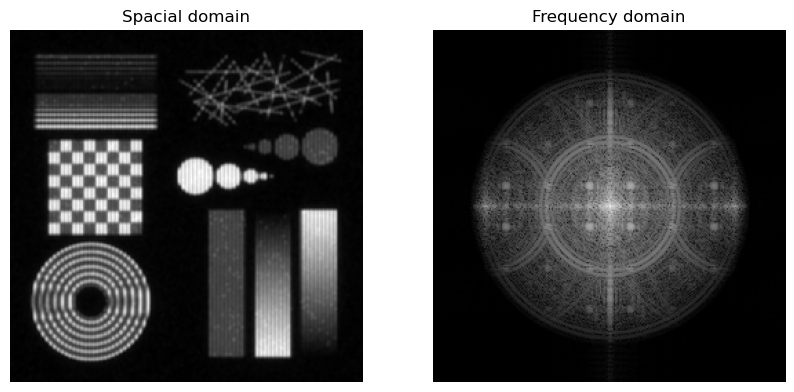

In [63]:
# Stitching
wiener_stitched = np.zeros_like(synthetic_grated_256)
wiener_stitched[:, :75, :115] = wiener_l1
wiener_stitched[:, 75:152, :115] = wiener_l2
wiener_stitched[:, 152:, :115] = wiener_l3
wiener_stitched[:, :72, 115:] = wiener_r1
wiener_stitched[:, 72:125, 115:] = wiener_r2
wiener_stitched[:, 125:, 115:] = wiener_r3

op.display_fourier(wiener_stitched[0]) # Noise free image

In [64]:
wiener_synthetic_grated_256 = np.zeros((9, 256, 256))

balance = 0.0001 # 1% 0.0001

for i in range(9):
    wiener_synthetic_grated_256[i] = ski.restoration.wiener(noisy_image[i], psf, balance)

wiener_PSNR = np.zeros(9)
wiener_SSIM = np.zeros(9)

for i in range(9):
    wiener_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], wiener_synthetic_grated_256[i])
    wiener_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], wiener_synthetic_grated_256[i], data_range=1)
    
print("Wiener PSNR: ", np.mean(wiener_PSNR))
print("Wiener SSIM: ", np.mean(wiener_SSIM))

# ski.io.imsave(os.path.join(folder_path, 'wiener_synthetic_grated_256.tif'), wiener_synthetic_grated_256)

Wiener PSNR:  30.209864320959216
Wiener SSIM:  0.7842326367572685


In [65]:
wiener_stitched_PSNR = np.zeros(9)
wiener_stitched_SSIM = np.zeros(9)

for i in range(9):
    wiener_stitched_PSNR[i] = ski.metrics.peak_signal_noise_ratio(synthetic_grated_256[i], wiener_stitched[i])
    wiener_stitched_SSIM[i] = ski.metrics.structural_similarity(synthetic_grated_256[i], wiener_stitched[i], data_range=1)
    
print("Wiener PSNR: ", np.mean(wiener_stitched_PSNR))
print("Wiener SSIM: ", np.mean(wiener_stitched_SSIM))

# ski.io.imsave(os.path.join(folder_path, 'wiener_stitched_256.tif'), wiener_stitched)


Wiener PSNR:  30.210530761707876
Wiener SSIM:  0.7842032367821494


In [66]:
clean_sim = ski.io.imread('output_images/synthetic_grated_256_sim.tif')[:, :, 0]
normal_sim = ski.io.imread('output_images/stitched/wiener_synthetic_grated_256_sim.tif')[:, :, 0]
stitched_sim = ski.io.imread('output_images/stitched/wiener_stitched_256_sim.tif')[:, :, 0]


n_psnr_value = ski.metrics.peak_signal_noise_ratio(clean_sim, normal_sim)
n_ssim_value = ski.metrics.structural_similarity(clean_sim, normal_sim, data_range=1)
s_psnr_value = ski.metrics.peak_signal_noise_ratio(clean_sim, stitched_sim)
s_ssim_value = ski.metrics.structural_similarity(clean_sim, stitched_sim, data_range=1)

print("Normal PSNR: ", np.mean(n_psnr_value))
print("Normal SSIM: ", np.mean(n_ssim_value))

print("Stitched PSNR: ", np.mean(s_psnr_value))
print("Stitched SSIM: ", np.mean(s_ssim_value))

Normal PSNR:  40.782857862766875
Normal SSIM:  0.8587052890126232
Stitched PSNR:  40.783367063148404
Stitched SSIM:  0.8585201566579759
